## Results of point pollution surface oil spill scenario at Turn Point
Dilbit Tanker fails to make the turn in outbound shipping lane at Turn Point and hits Arachne Reef, spilling 2000 m<sup>-3</sup> of Dilbit.

In [1]:
import os
import xarray as xr
import numpy as np
import itertools
import pandas as pd
from pathlib import Path
import geopandas as gpd
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import ssam_groups as groups
import ssam_plot as splot
from mpl_toolkits.axes_grid1 import make_axes_locatable

### Define scenario and control files

In [2]:
affected_boxes = [1, 2, 3, 4, 5, 6, 7, 8, 9, 60, 33, 66]

In [3]:
hex_colour = '#6DB48E'
hatches = ['oo', '///', 'xx', '++']

In [4]:
# Oil injection file 
oil_root = Path('/ocean/rlovindeer/MOAD/analysis-raisha/notebooks/contaminant-dispersal/results/ForcingFiles/')
oil_paths = sorted([p for p in oil_root.glob('SSAM_Scenario_5b*_10000_fromzarr.nc')])
oil_files = [xr.open_dataset(oil_scen,decode_cf=True) for oil_scen in oil_paths]

In [5]:
# Read in salish sea atlantis output files.
scenario_root = Path('/ocean/rlovindeer/MOAD/analysis-raisha/SSmodel_outputs/Spills/MPRI-1')

control_file = "/ocean/rlovindeer/MOAD/analysis-raisha/SSmodel_outputs/Tests/v6719_50y_VBITBUCKET-ddmove0-2-ZGppreyWS-1-PL-fishing/outputSalishSea.nc"
control = xr.open_dataset(str(control_file), decode_cf=True)
time = np.ma.filled(control.variables['t'])


In [6]:
scenario_paths = sorted([p for p in scenario_root.glob('Scenario_5b*/outputSalishSea.nc')])
for path in scenario_paths:
    print(path.parent.stem, groups.conditions[str(path.parent.stem).split(sep = '_')[3]])

Scenario_5b_1_2019-01-20 low Fraser flow spring tide winter
Scenario_5b_2_2019-01-14 low Fraser flow neap tide winter
Scenario_5b_3_2020-01-24 high Fraser flow spring tide winter
Scenario_5b_4_2020-01-16 high Fraser flow neap tide winter


In [7]:
scenario_datasets = [xr.open_dataset(scen,decode_cf=True) for scen in scenario_paths]

In [8]:
# time after burn-in
start = 100
end = time.size-1

In [9]:
# Reading in Atlantis map
shapefile_name = "/ocean/rlovindeer/Atlantis/ssam_oceanparcels/SalishSea/SalishSea_July172019_2/SalishSea_July172019.shp"
data_df_original = gpd.read_file(shapefile_name)
data_df_original = data_df_original.sort_values(by=['BOX_ID'])
data_df = data_df_original.set_index('BOX_ID')
box_depth = data_df['BOTZ']
land_boxes = box_depth==0
land_boxes = data_df.index[land_boxes]
land_df = data_df.loc[land_boxes]
jdf_df = data_df.loc[data_df.Region=='Juan de Fuca']
hs_df = data_df.loc[data_df.Region=='Howe Sound']
strait_df = data_df.loc[data_df.Region=='Strait of Georgia']
ps_df = data_df.loc[data_df.Region=='Puget Sound']

### Mapping spill extent

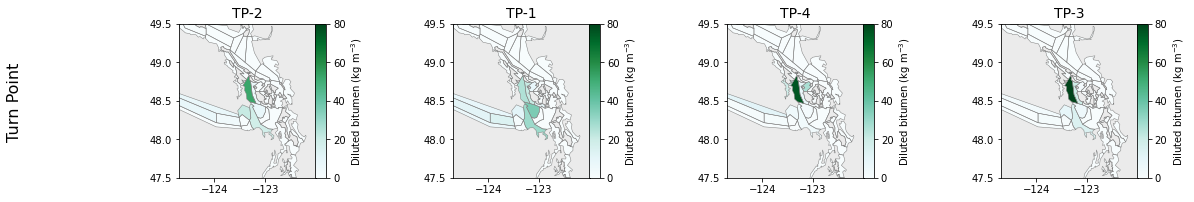

In [10]:
fig = plt.figure(figsize=(18, 6), facecolor='white') #figsize=(9, 12)
gs = plt.GridSpec(1, len(oil_files), wspace=0.5, hspace=0.2, height_ratios=[1],)

position = 0

for file, oil_path in zip(oil_files, oil_paths):
    date = str(oil_path).split(sep = '_')[3]
    label = 'TP-'+ str(groups.simulations[groups.conditions[date]])
    oil_tb = file.variables['oil']
    oil_b = oil_tb.mean(axis=0)

    # Add scenario data to Atlantis spatial data
    data_df['oil'] = oil_b
    data_df.loc[land_boxes, 'oil'] = 0
    #oil_df = data_df.loc[data_df['oil'] > 0]

    ax = fig.add_subplot(gs[0, position], facecolor = '#EBEBEB')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=-0.5)
    ax = data_df.plot(column = 'oil', ax=ax, cax=cax,cmap=cm.BuGn, legend_kwds={'label': 'Diluted bitumen (kg m$^{-3}$)'}, vmax=80,
    #ax = data_df.plot(column = 'BOTZ', ax=ax, cax=cax,cmap=cm.Blues, legend_kwds={'label': 'depth (m)'},
    legend=True, 
    )
    ax.set_title(label, fontsize = 14)
    ax.set_xlim(-124.7)
    ax.set_ylim(47.5, 49.5)
    data_df.boundary.plot(ax=ax, color='grey', linewidths=0.5)
    land_df.plot(ax=ax, color='#EBEBEB')
    #oil_df.plot(ax=ax, color='red',linewidths=0.5)
    position = position+1
fig.supylabel('Turn Point', fontsize = 16); #color=hex_colour

#### Concentration of PAH in seawater

Half lives

| PAH Concentration	|	Naphthalene |	Phenanthrene | Pyrene |	Benzo(a)pyrene |
|-------------------|---------------|-----------------|--------|----------|
| Half life (secs)	|	259200 |	3628800	| 20476800	| 19353600 |
| Half life (days)	|	3	| 42 |	237 |	224 |

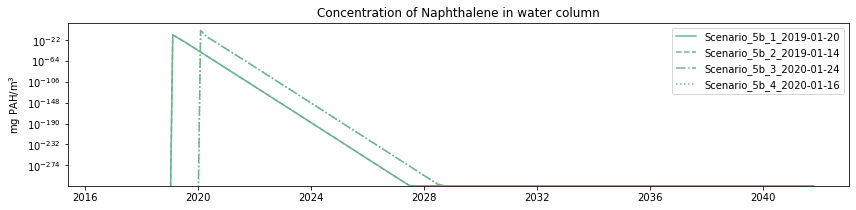

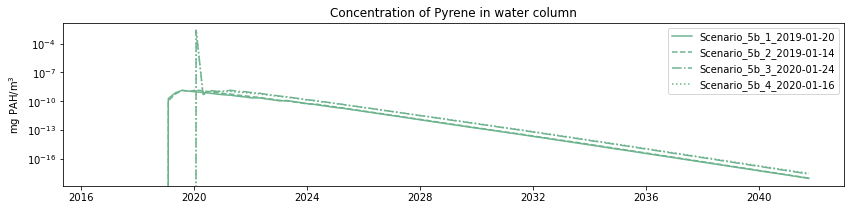

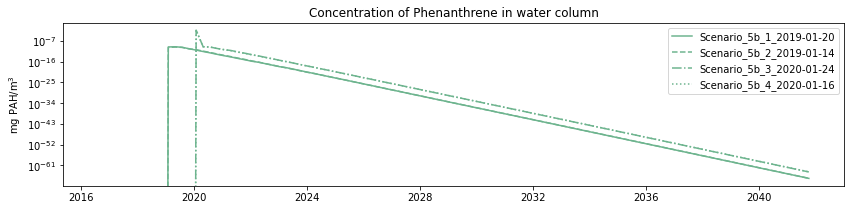

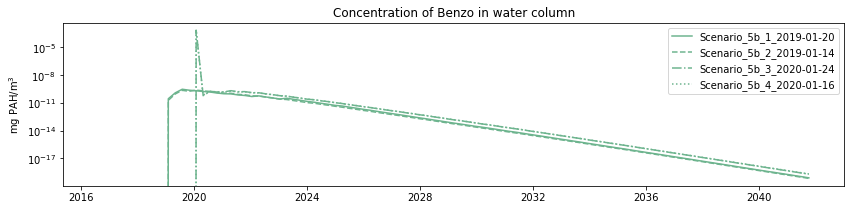

In [12]:
for pah in groups.pahs:
  fig, ax = plt.subplots(figsize = (14,3))
  names = []
  line_styles = itertools.cycle(('-', '--', '-.', ':',(5, (10, 3)),
    (0, (3, 1, 1, 1)),(0, (1, 1)),(0, (3, 10, 1, 10, 1, 10))))
  for scenario, path, i in zip(scenario_datasets,scenario_paths,range(0,len(scenario_datasets))):
      nm = path.parent.stem
      names.append(nm)
      contam_tbl = scenario.variables[str(pah)][start:end,:,0:6]
      contam_tb = contam_tbl.sum(axis=2)
      contam_t = contam_tb.sum(axis=1)
      ax.semilogy(scenario.t[start:end], contam_t, color=hex_colour, linestyle=next(line_styles))
  ax.set_title('Concentration of '+ pah +' in water column', fontsize = 12)
  ax.set_ylabel('mg PAH/m$^3$')
  ax.legend(names, loc='best')

## Results
### Time-separate box plots

In [10]:
print('closest time points to 2019 spill: ' + str(time[110]))
print('5 years post spill: ' + str((time[130])))
print('10 years post spill: ' + str(time[151]))
print('20 years post spill: ' + str(time[191]))

closest time points to 2019 spill: 2019-02-07T14:00:00.000000000
5 years post spill: 2024-01-12T14:00:00.000000000
10 years post spill: 2029-03-16T14:00:00.000000000
20 years post spill: 2039-01-23T14:00:00.000000000


In [15]:
print('closest time points to 2020 spill: ' + str(time[118]))
print('5 years post spill: ' + str((time[134])))
print('10 years post spill: ' + str(time[154]))
print('20 years post spill: ' + str(time[195]))

closest time points to 2020 spill: 2021-01-27T14:00:00.000000000
5 years post spill: 2025-01-06T14:00:00.000000000
10 years post spill: 2029-12-11T14:00:00.000000000
20 years post spill: 2040-01-18T14:00:00.000000000


In [16]:
days2019winter = [110, 130, 151, 191]
days2020winter = [118, 134, 154, 195]

In [39]:
def progressive_boxplot_pelagic(bio_group, location=groups.salish_sea, x_lim=None):
    all_results = []
    data_labels = ['spill year', '5 years later', '10 years later', '20 years later']

    for scenario, path in zip(scenario_datasets, scenario_paths):
        nm = str(path.parent.stem).split(sep='_')
        year = str(nm[3]).split(sep='-')[0]
        scenario_name = 'TP-'+nm[2]  

        if year == '2019':
            end_days = days2019winter
        elif year == '2020':
            end_days = days2020winter

        for species in bio_group:
            results = []
            for day in end_days:
                p_oiled = np.ma.filled(scenario.variables[bio_group[species] + '_N'][start:day, location, 0:6], np.nan)
                p_control = np.ma.filled(control.variables[bio_group[species] + '_N'][start:day, location, 0:6], np.nan)
                
                p_oiled = p_oiled.sum(axis=(1, 2)).mean()
                p_control = p_control.sum(axis=(1, 2)).mean()
                
                ratio = (p_oiled / p_control - 1) * 100
                results.append(ratio)

            for label, value in zip(data_labels, results):
                all_results.append({
                    'bio_group': bio_group[species],
                    'sensitivity': groups.sensitivity[species],
                    'sensitivity_negative': -groups.sensitivity[species],
                    'time_label': label,
                    'scenario': scenario_name,
                    'percent_change': value
                })

    # Step 2: Convert to DataFrame
    df = pd.DataFrame(all_results)
    #df.to_csv("/ocean/rlovindeer/MOAD/analysis-raisha/SSmodel_outputs/Spills/MPRI-1/5b-turn-point-"+str(bio_group[species])+".csv")
    #print(df)
    
    time_labels = df['time_label'].unique()
    bio_groups = df['bio_group'].unique()
    scenarios = df['scenario'].unique()
    colors = plt.cm.tab10.colors

    n_rows = len(bio_groups)
    if n_rows < 7:
        n_rows = 7
    elif n_rows >10:
        n_rows = 15
    else:
         n_rows = n_rows
    n_cols = len(time_labels)
    fig, axes = plt.subplots(1, n_cols, figsize=(5 * n_cols, n_rows), sharey=True)

    if n_cols == 1:
        axes = [axes]

    bar_width = 0.8 / len(scenarios)  
    y_pos = np.arange(len(bio_groups))

    for i, time in enumerate(time_labels):
        ax = axes[i]
        for j, scenario in enumerate(scenarios):
            df_plot = df[(df['time_label'] == time) & (df['scenario'] == scenario)]
            df_plot = df_plot.set_index('bio_group').reindex(bio_groups) 
            offset = (j - len(scenarios)/2) * bar_width + bar_width/2

            ax.barh(y_pos + offset, df_plot['percent_change'], height=bar_width, label=scenario, facecolor=hex_colour, edgecolor='black', hatch=hatches[j])
        ax.barh(bio_groups, df_plot['sensitivity'], label=scenario, color='grey', alpha=0.3)
        ax.barh(bio_groups, df_plot['sensitivity_negative'], label=scenario, color='grey', alpha=0.3)
        ax.xaxis.grid(True)
                
        ax.set_title(time)
        ax.set_yticks(y_pos)
        ax.set_yticklabels(bio_groups, fontsize=12) 
        ax.set_xlim(x_lim)
        ax.set_xlabel("Percent Change")

    fig.legend(np.append(scenarios,'model threshold'), loc='upper center', ncol=len(scenarios)+1, fontsize=12)
    #plt.tight_layout(rect=[0, 0, 1, 0.95])
    #axes[0].set_ylabel(bio_groups)
    plt.show()

In [40]:
def progressive_boxplot_benthic(bio_group, location=groups.salish_sea, x_lim=None):
    all_results = []
    data_labels = ['spill year', '5 years later', '10 years later', '20 years later']

    for scenario, path in zip(scenario_datasets, scenario_paths):
        nm = str(path.parent.stem).split(sep='_')
        year = str(nm[3]).split(sep='-')[0]
        scenario_name = 'TP-'+nm[2]

        if year == '2019':
            end_days = days2019winter
        elif year == '2020':
            end_days = days2020winter

        for species in bio_group:
            results = []
            for day in end_days:
                p_oiled = np.ma.filled(scenario.variables[bio_group[species] + '_N'][start:day, location], np.nan)
                p_control = np.ma.filled(control.variables[bio_group[species] + '_N'][start:day, location], np.nan)
                
                p_oiled = p_oiled.sum(axis=(1)).mean()
                p_control = p_control.sum(axis=(1)).mean()
                
                ratio = (p_oiled / p_control - 1) * 100
                results.append(ratio)

            for label, value in zip(data_labels, results):
                all_results.append({
                    'bio_group': bio_group[species],
                    'sensitivity': groups.sensitivity[species],
                    'sensitivity_negative': -groups.sensitivity[species],
                    'time_label': label,
                    'scenario': scenario_name,
                    'percent_change': value
                })

    df = pd.DataFrame(all_results)
    #df.to_csv("/ocean/rlovindeer/MOAD/analysis-raisha/SSmodel_outputs/Spills/MPRI-1/affected-boxes-5b-turn-point-benthos.csv")
    #print(df)

    time_labels = df['time_label'].unique()
    bio_groups = df['bio_group'].unique()
    scenarios = df['scenario'].unique()
    colors = plt.cm.tab10.colors

    n_rows = 1
    n_cols = len(time_labels)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 6), sharey=True)

    if n_cols == 1:
        axes = [axes]  

    bar_width = 0.8 / len(scenarios)  
    y_pos = np.arange(len(bio_groups))

    for i, time in enumerate(time_labels):
        ax = axes[i]
        for j, scenario in enumerate(scenarios):
            df_plot = df[(df['time_label'] == time) & (df['scenario'] == scenario)]
            df_plot = df_plot.set_index('bio_group').reindex(bio_groups)  # Ensure consistent order
            offset = (j - len(scenarios)/2) * bar_width + bar_width/2

            ax.barh(y_pos + offset, df_plot['percent_change'], height=bar_width, label=scenario, facecolor=hex_colour, edgecolor='black', hatch=hatches[j])
        ax.barh(bio_groups, df_plot['sensitivity'], label=scenario, color='grey', alpha=0.3)
        ax.barh(bio_groups, df_plot['sensitivity_negative'], label=scenario, color='grey', alpha=0.3)
        ax.xaxis.grid(True)
    
        ax.set_title(time)
        ax.set_yticks(y_pos)
        ax.set_yticklabels(bio_groups, fontsize=12) 
        ax.set_xlim(x_lim)
        ax.set_xlabel("Percent Change")

    fig.legend(np.append(scenarios,'model threshold'), loc='upper center', ncol=len(scenarios)+1, fontsize=12)
    #plt.tight_layout(rect=[0, 0, 1, 0.95])
    #axes[0].set_ylabel(bio_groups)
    plt.show()

In [41]:
def progressive_boxplot_vertebrates(bio_group, location=groups.salish_sea, x_lim=None):
    all_results = []
    data_labels = ['spill year', '5 years later', '10 years later', '20 years later']

    for scenario, path in zip(scenario_datasets, scenario_paths):
        nm = str(path.parent.stem).split(sep='_')
        year = str(nm[3]).split(sep='-')[0]
        scenario_name = 'TP-'+nm[2]  # Readable scenario name

        if year == '2019':
            end_days = days2019winter
        elif year == '2020':
            end_days = days2020winter

        for species in bio_group:
            results = []
            numCohorts = groups.cohorts[bio_group[species]]
            for day in end_days:

                sum_ratio = 0

                for cohort in range (1, numCohorts+1):

                    new_species = bio_group[species] + str(cohort)
                
                    o_numbers_tbl = np.ma.filled(scenario.variables[new_species + '_Nums'][start:day, location, 0:6], np.nan)
                    o_structuralN_tbl = np.ma.filled(scenario.variables[new_species +'_StructN'][start:day, location, 0:6], np.nan)
                    o_reservedN_tbl = np.ma.filled(scenario.variables[new_species +'_ResN'][start:day, location, 0:6], np.nan)

                    c_numbers_tbl = np.ma.filled(control.variables[new_species + '_Nums'][start:day, location, 0:6], np.nan)
                    c_structuralN_tbl = np.ma.filled(control.variables[new_species +'_StructN'][start:day, location, 0:6], np.nan)
                    c_reservedN_tbl = np.ma.filled(control.variables[new_species +'_ResN'][start:day, location, 0:6], np.nan)

                    o_weightatage_tbl = (o_structuralN_tbl + o_reservedN_tbl) * o_numbers_tbl 
                    o_weightatage = o_weightatage_tbl.sum(axis=(1,2)).mean()

                    c_weightatage_tbl = (c_structuralN_tbl + c_reservedN_tbl) * c_numbers_tbl 
                    c_weightatage = c_weightatage_tbl.sum(axis=(1,2)).mean()

                    #difference = o_weightatage_tb.sum(axis=1) - c_weightatage_tb.sum(axis=1) 
                    ratio = (o_weightatage / c_weightatage - 1) * 100
                    #print(ratio)
                    sum_ratio = sum_ratio + ratio

                results.append(sum_ratio/numCohorts)

            for label, value in zip(data_labels, results):
                all_results.append({
                    'bio_group': bio_group[species],
                    'sensitivity': groups.sensitivity[species],
                    'sensitivity_negative': -groups.sensitivity[species],
                    'time_label': label,
                    'scenario': scenario_name,
                    'percent_change': value
                })

    df = pd.DataFrame(all_results)
    #df.to_csv("/ocean/rlovindeer/MOAD/analysis-raisha/SSmodel_outputs/Spills/MPRI-1/6a-english-bay-"+str(bio_group[species])+".csv")
    #print(df)
    
    time_labels = df['time_label'].unique()
    bio_groups = df['bio_group'].unique()
    scenarios = df['scenario'].unique()
    colors = plt.cm.tab10.colors

    n_rows = len(bio_groups)
    n_cols = len(time_labels)
    fig, axes = plt.subplots(1, n_cols, figsize=(5 * n_cols, n_rows+1), sharey=True)

    if n_cols == 1:
        axes = [axes]  # Make iterable if only 1 subplot

    bar_width = 0.8 / len(scenarios)  # space per group divided by number of scenarios
    y_pos = np.arange(len(bio_groups))

    for i, time in enumerate(time_labels):
        ax = axes[i]
        for j, scenario in enumerate(scenarios):
            df_plot = df[(df['time_label'] == time) & (df['scenario'] == scenario)]
            df_plot = df_plot.set_index('bio_group').reindex(bio_groups)  # Ensure consistent order
            offset = (j - len(scenarios)/2) * bar_width + bar_width/2

            ax.barh(y_pos + offset, df_plot['percent_change'], height=bar_width, label=scenario, facecolor=hex_colour, edgecolor='black', hatch=hatches[j])
        ax.barh(bio_groups, df_plot['sensitivity'], label=scenario, color='grey', alpha=0.3)
        ax.barh(bio_groups, df_plot['sensitivity_negative'], label=scenario, color='grey', alpha=0.3)
        ax.xaxis.grid(True)
       
        ax.set_title(time, fontsize=15)
        ax.set_yticks(y_pos)
        ax.set_yticklabels(bio_groups, fontsize=15) 
        ax.set_xlim(x_lim)
        ax.set_xlabel("Percent Change", fontsize=13)

    fig.legend(np.append(scenarios,'model threshold'), loc='upper center', ncol=len(scenarios)+1, fontsize=15) 
    #plt.tight_layout(rect=[0, 0, 1, 0.95])
    #axes[0].set_ylabel(bio_groups)
    plt.show()

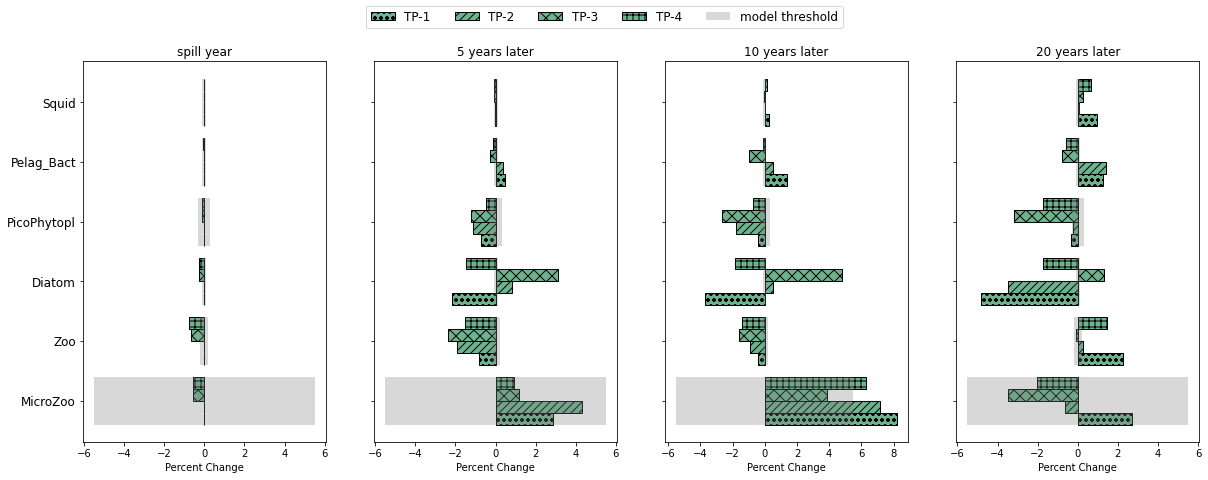

In [20]:
progressive_boxplot_pelagic(groups.planktonic)

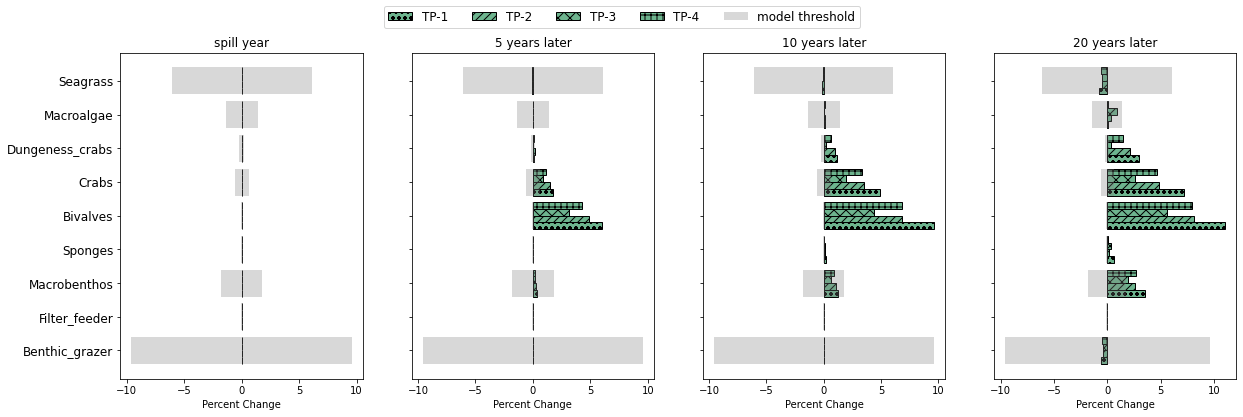

In [21]:
progressive_boxplot_benthic(groups.benthos)

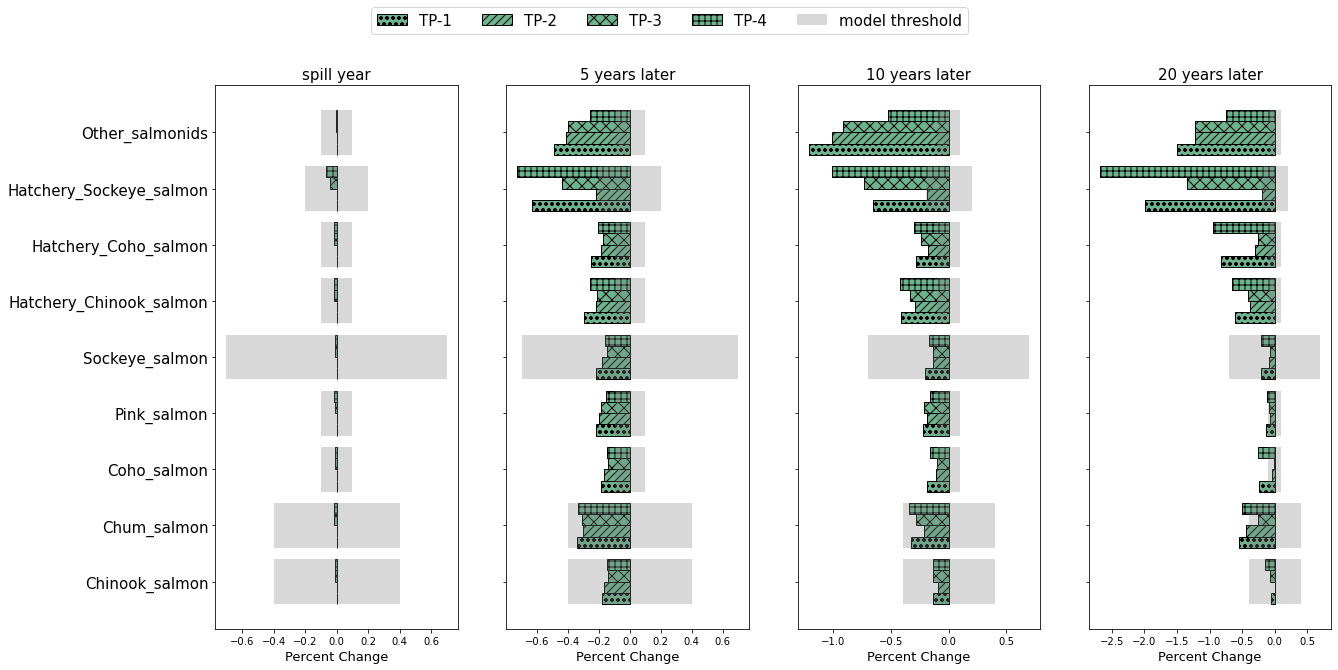

In [29]:
progressive_boxplot_vertebrates(groups.salmon)

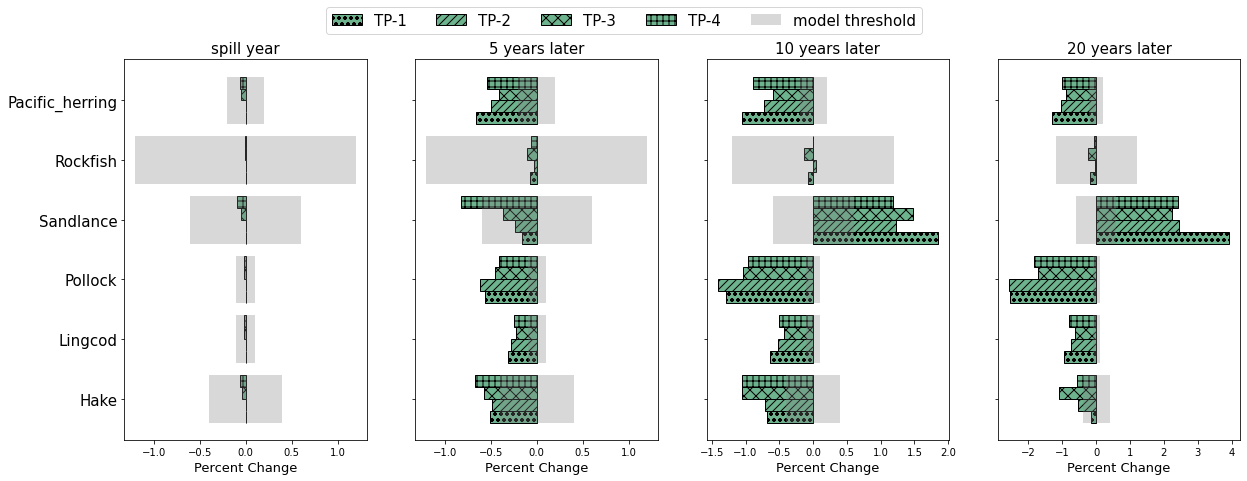

In [30]:
progressive_boxplot_vertebrates(groups.named_fish)

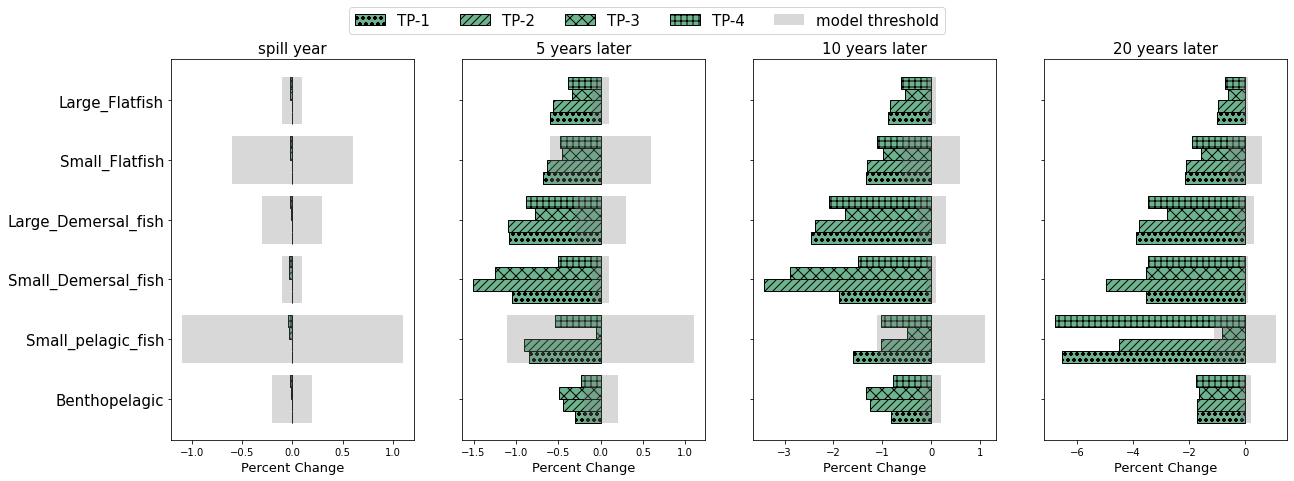

In [31]:
progressive_boxplot_vertebrates(groups.other_fish)

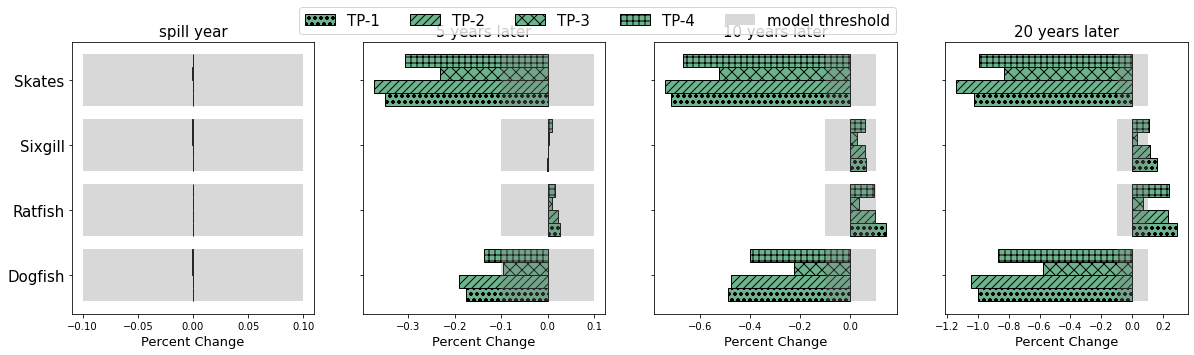

In [32]:
progressive_boxplot_vertebrates(groups.sharks)

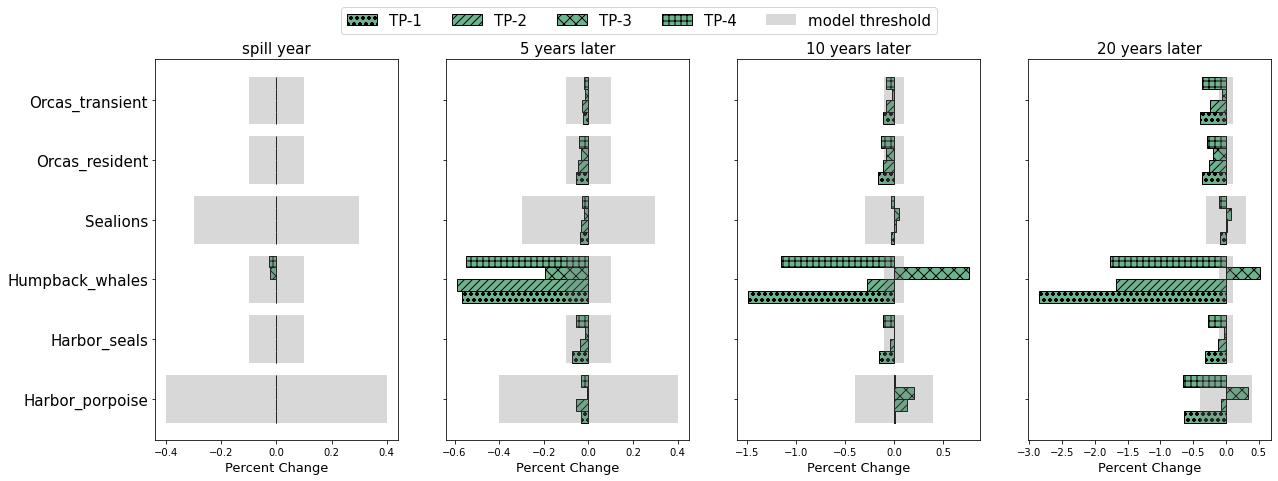

In [33]:
progressive_boxplot_vertebrates(groups.mammals)

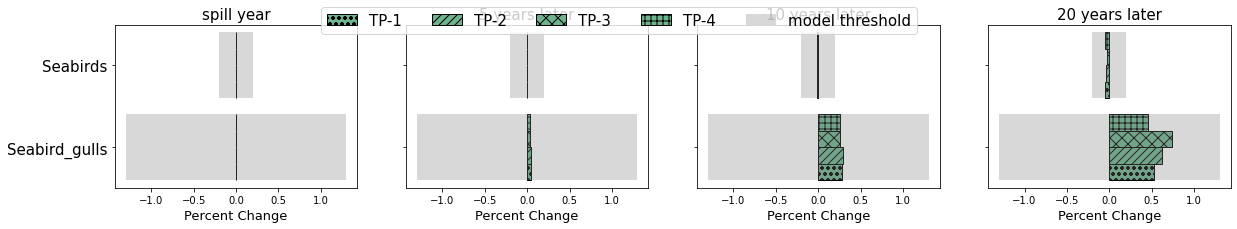

In [34]:
progressive_boxplot_vertebrates(groups.birds)

## Regional changes

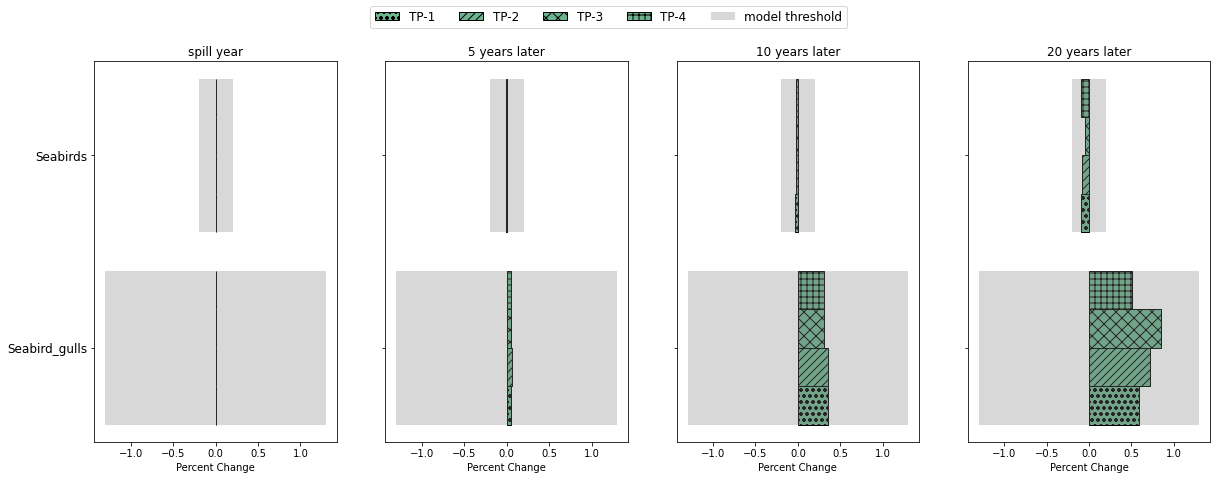

In [36]:
progressive_boxplot_pelagic(groups.birds, location=affected_boxes)

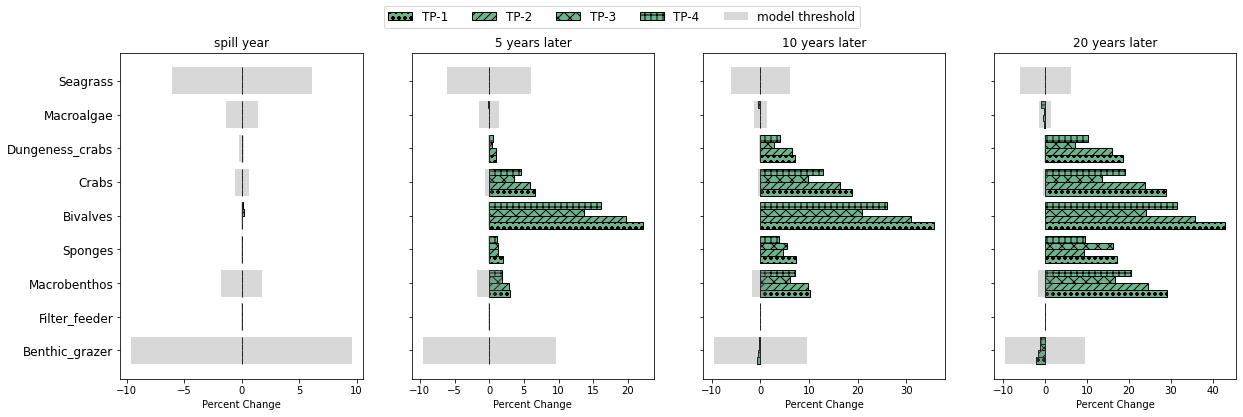

In [37]:
progressive_boxplot_benthic(groups.benthos, location=affected_boxes) # x_lim=[-25, 85]

### affected groups

In [38]:
affected_pelagic = { # greater than a 5% change across the entire model, plus any change above threshold for mammals
    'porpoises':'Harbor_porpoise', 'humpbacks':'Humpback_whales',
    #'resident orcas':'Orcas_resident', 'transient orcas':'Orcas_transient', 
    'dogfish':'Dogfish','skates':'Skates',
    'Chum':'Chum_salmon', 'Hatchery Coho':'Hatchery_Coho_salmon','Hatchery Sockeye':'Hatchery_Sockeye_salmon',
    'Other salmonids':'Other_salmonids'
}

affected_fish = {
    'hake':'Hake','sandlance':'Sandlance', 'pacific herring':'Pacific_herring',
    'large demersal':'Large_Demersal_fish', 'small flatfish':'Small_Flatfish', 
    'benthopelagic':'Benthopelagic', 'small demersal':'Small_Demersal_fish', 'small pelagic':'Small_pelagic_fish',
}

affected_benthos = {'macrobenthos':'Macrobenthos',  
    'sponges':'Sponges', 'bivalves':'Bivalves', 'crabs':'Crabs', 'dungeness crabs':'Dungeness_crabs',
    #'macroalgae':'Macroalgae', 'seagrass':'Seagrass', 
}

affected_all_verts = { # greater than a 5% change across the entire model, plus any change above threshold for mammals
    'porpoises':'Harbor_porpoise', 'humpbacks':'Humpback_whales',
    #'resident orcas':'Orcas_resident', 'transient orcas':'Orcas_transient', 
    'dogfish':'Dogfish','skates':'Skates',
    'Chum':'Chum_salmon', 'Hatchery Coho':'Hatchery_Coho_salmon','Hatchery Sockeye':'Hatchery_Sockeye_salmon',
    'Other salmonids':'Other_salmonids',
    'hake':'Hake','sandlance':'Sandlance', 'pacific herring':'Pacific_herring',
    'large demersal':'Large_Demersal_fish', 'small flatfish':'Small_Flatfish', 
    'benthopelagic':'Benthopelagic', 'small demersal':'Small_Demersal_fish', 'small pelagic':'Small_pelagic_fish',
}

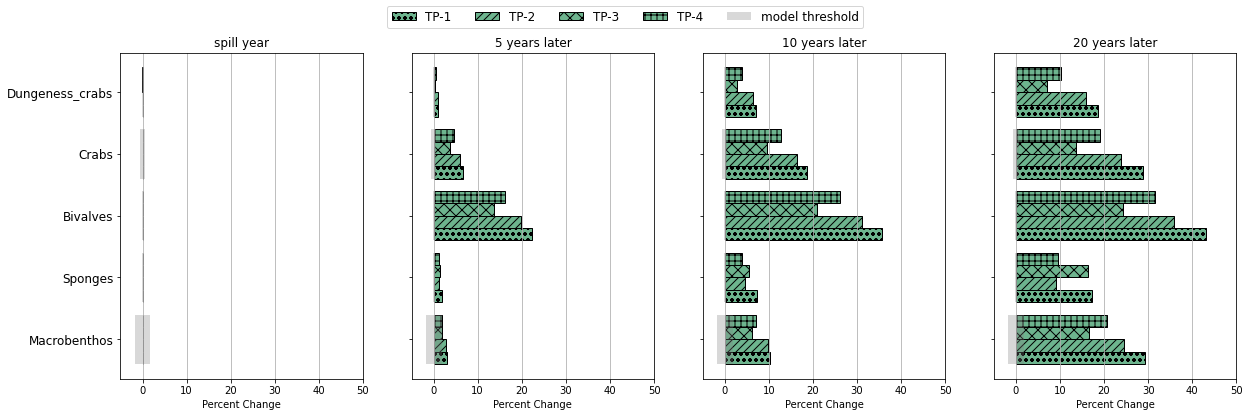

In [42]:
progressive_boxplot_benthic(affected_benthos, location=affected_boxes, x_lim=[-5, 50])

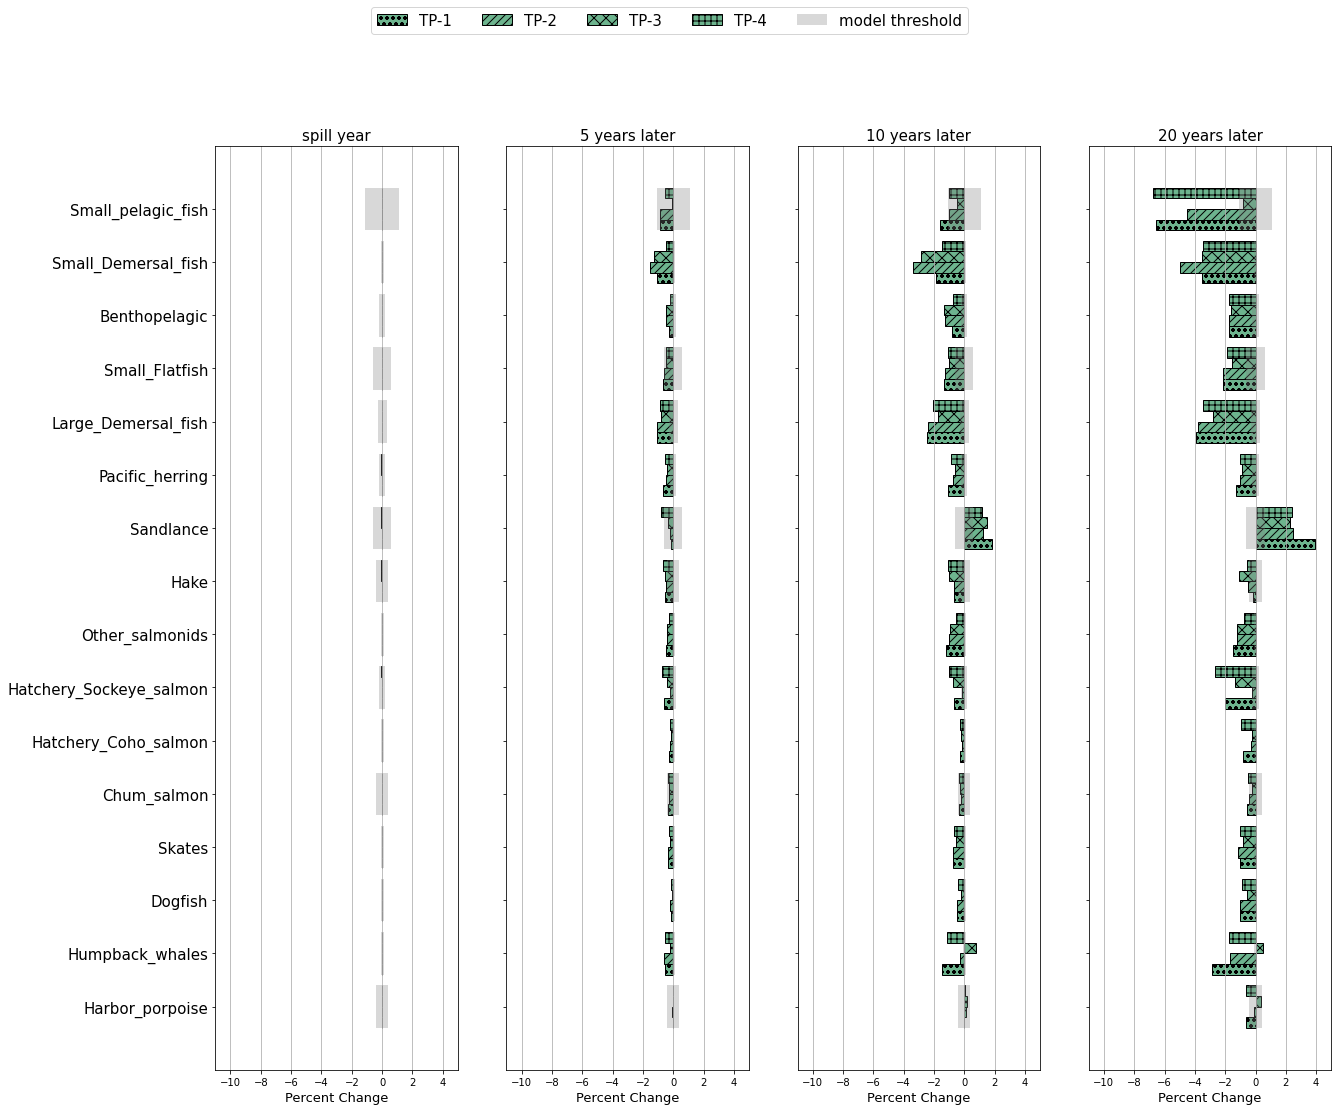

In [44]:
progressive_boxplot_vertebrates(affected_all_verts,  x_lim=[-11, 5])

## Highres Results

In [6]:
highres_control_file = "/ocean/rlovindeer/MOAD/analysis-raisha/SSmodel_outputs/Spills/MPRI-1/highres-control-3y/outputSalishSea.nc"
highres_control = xr.open_dataset(str(highres_control_file), decode_cf=True)
highres_time = np.ma.filled(highres_control.variables['t'])

In [7]:
highres_paths = sorted([p for p in scenario_root.glob('highres-scenario_5b*/outputSalishSea.nc')])
highres_datasets = [xr.open_dataset(scen,decode_cf=True) for scen in highres_paths]
for path in highres_paths:
    print(path.parent.stem)

highres-scenario_5b_1_2019-01-20
highres-scenario_5b_2_2019-01-14
highres-scenario_5b_3_2020-01-24
highres-scenario_5b_4_2020-01-16


In [10]:
def plot_groups_pelagic_N(bio_group, scenario_datasets, scenario_paths, control=control, boxes=groups.salish_sea, y_min=None, y_max=None):

    fig = plt.figure(figsize=(18, 18), facecolor='white')
    gs = plt.GridSpec(3, 3, wspace=0.2, hspace=0.2, width_ratios=[1, 1, 1], height_ratios=[1, 1, 1], )
    line_styles = itertools.cycle(('-', '--', '-.', ':',(5, (10, 3)),
    (0, (3, 1, 1, 1)),(0, (1, 1)),(0, (3, 10, 1, 10, 1, 10))))

    for species in bio_group:
        names = ['control']
        bio_index = (list(bio_group).index(species))
        if bio_index < 3:
            position = 0, bio_index
        elif bio_index > 5: 
            position = 2, bio_index-6
        else :
            position = 1, bio_index-3
        ax = fig.add_subplot(gs[position])

        pelagic_control = np.ma.filled(control.variables[bio_group[species] + '_N'][:,boxes,0:6], np.nan)
        pelagic_control = pelagic_control.sum(axis=2)
        pelagic_control = pelagic_control.sum(axis=1)
        control_ratio = (pelagic_control / pelagic_control-1)*100
        ax.plot(control.t, control_ratio, 'k', linewidth = 2)
    
        for scenario, path in zip(scenario_datasets, scenario_paths):
            nm = str(path.parent.stem).split(sep='_')
            scenario_name = 'TP-'+nm[2]  
            names.append(scenario_name)

            pelagic_oiled = np.ma.filled(scenario.variables[bio_group[species] + '_N'][:,boxes,0:6], np.nan) # tonnes
            pelagic_oiled = pelagic_oiled.sum(axis=2) 
            pelagic_oiled = pelagic_oiled.sum(axis=1) 
            ratio = (pelagic_oiled / pelagic_control-1)*100
            ax.plot(scenario.t, ratio, linewidth = 2, color=hex_colour, linestyle=next(line_styles))
        ax.fill_between(scenario.t, -groups.sensitivity[species], groups.sensitivity[species],
            color='grey', alpha=0.3, label='Model threshold')
       
        ax.set_ylabel('Percent (%) change', fontsize=12)
        ax.set_title(species)
        ax.set_ylim([y_min, y_max])
    ax.legend(names, fontsize=12); #bbox_to_anchor=(1.05, 1)

In [11]:
def plot_groups_benthic_N(bio_group, scenario_datasets, scenario_paths, control=control, boxes=groups.salish_sea, y_min=None, y_max=None):

    fig = plt.figure(figsize=(18, 18), facecolor='white')
    gs = plt.GridSpec(3, 3, wspace=0.2, hspace=0.2, width_ratios=[1, 1, 1], height_ratios=[1, 1, 1], )
    line_styles = itertools.cycle(('-', '--', '-.', ':',(5, (10, 3)),
    (0, (3, 1, 1, 1)),(0, (1, 1)),(0, (3, 10, 1, 10, 1, 10))))

    for species in bio_group:
        names = ['control']
        bio_index = (list(bio_group).index(species))
        if bio_index < 3:
            position = 0, bio_index
        elif bio_index > 5: 
            position = 2, bio_index-6
        else :
            position = 1, bio_index-3
        ax = fig.add_subplot(gs[position])

        pelagic_control = np.ma.filled(control.variables[bio_group[species] + '_N'][:,boxes], np.nan)
        pelagic_control = pelagic_control.sum(axis=1)
        control_ratio = (pelagic_control / pelagic_control-1)*100
        ax.plot(control.t, control_ratio, 'k', linewidth = 2)
    
        for scenario, path in zip(scenario_datasets, scenario_paths):
            nm = str(path.parent.stem).split(sep='_')
            scenario_name = 'TP-'+nm[2]  
            names.append(scenario_name)

            pelagic_oiled = np.ma.filled(scenario.variables[bio_group[species] + '_N'][:,boxes], np.nan) # tonnes
            pelagic_oiled = pelagic_oiled.sum(axis=1) 
            ratio = (pelagic_oiled / pelagic_control-1)*100
            ax.plot(scenario.t, ratio, linewidth = 2, color=hex_colour, linestyle=next(line_styles))
        ax.fill_between(scenario.t, -groups.sensitivity[species], groups.sensitivity[species],
            color='grey', alpha=0.3, label='Model threshold')
       
        ax.set_ylabel('Percent (%) change', fontsize=12)
        ax.set_title(species)
        ax.set_ylim([y_min, y_max])
    ax.legend(names, fontsize=12); #bbox_to_anchor=(1.05, 1)

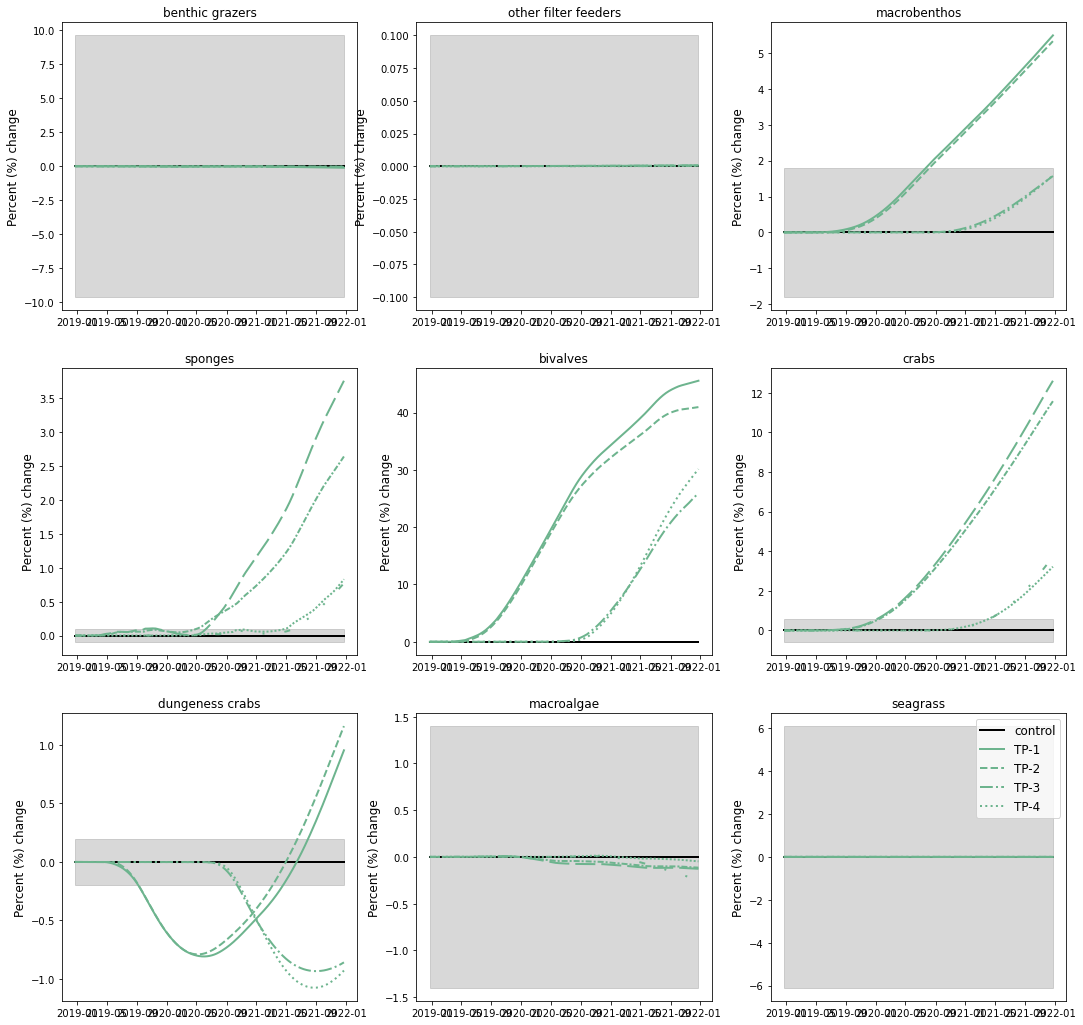

In [52]:
plot_groups_benthic_N(groups.benthos, highres_datasets, highres_paths, control=highres_control, boxes=affected_boxes)

In [34]:
def plot_benthic_biomass(bio_group, scenario_datasets, scenario_paths, control=control, boxes=groups.salish_sea, y_min=None, y_max=None):

    fig = plt.figure(figsize=(18, 18), facecolor='white')
    gs = plt.GridSpec(3, 3, wspace=0.2, hspace=0.2, width_ratios=[1, 1, 1], height_ratios=[1, 1, 1], )
    line_styles = itertools.cycle(('-', '--', '-.', ':',(5, (10, 3)),
    (0, (3, 1, 1, 1)),(0, (1, 1)),(0, (3, 10, 1, 10, 1, 10))))

    for species in bio_group:
        names = ['control']
        bio_index = (list(bio_group).index(species))
        if bio_index < 3:
            position = 0, bio_index
        elif bio_index > 5: 
            position = 2, bio_index-6
        else :
            position = 1, bio_index-3
        ax = fig.add_subplot(gs[position])

        pelagic_control = np.ma.filled(control.variables[bio_group[species] + '_N'][:,boxes], np.nan)
        pelagic_control = pelagic_control.sum(axis=1)
        ax.plot(control.t, pelagic_control, 'k')
    
        for scenario, path in zip(scenario_datasets, scenario_paths):
            nm = str(path.parent.stem).split(sep='_')
            scenario_name = 'TP-'+nm[2]  
            names.append(scenario_name)

            pelagic_oiled = np.ma.filled(scenario.variables[bio_group[species] + '_N'][:,boxes], np.nan) # tonnes
            pelagic_oiled = pelagic_oiled.sum(axis=1) 
            ax.plot(scenario.t, pelagic_oiled, linewidth = 2, color=hex_colour, linestyle=next(line_styles))
        
        ax.set_ylabel('Biomass', fontsize=12)
        ax.set_title(species)
        ax.set_ylim([y_min, y_max])
    ax.legend(names, fontsize=12); #bbox_to_anchor=(1.05, 1)

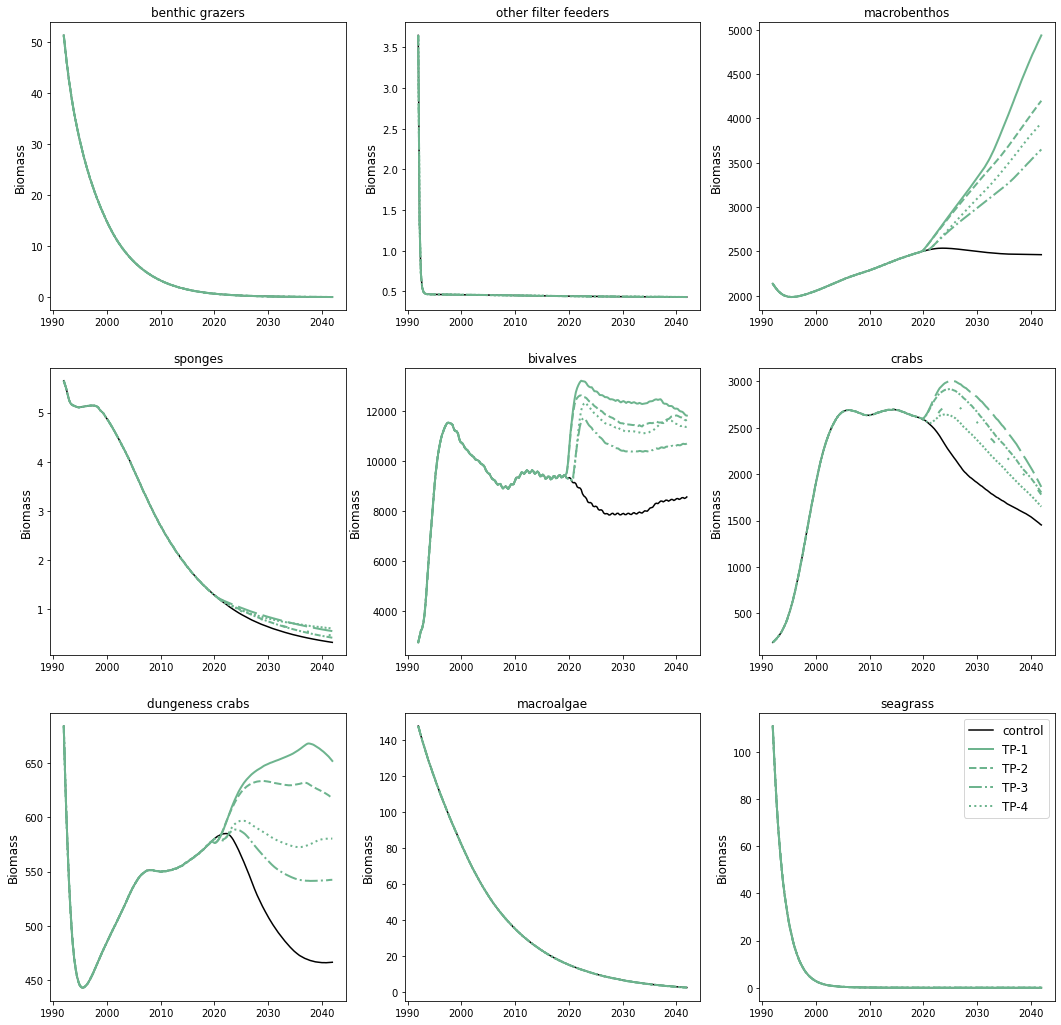

In [35]:
plot_benthic_biomass(groups.benthos, scenario_datasets, scenario_paths, boxes=affected_boxes)